## Seismic model

### Function

In [1]:
from dwave.system import DWaveSampler, EmbeddingComposite # type: ignore
from modules import construct_Ad, binary2real
from modules import binary_least_squares_qubo, dict_to_vector_auto
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import os
from tqdm import tqdm  # type: ignore

# Functions
def velocity_generator(rows, cols):
    grid_size = (rows, cols)
    min_velocity = 3460
    max_velocity = 3530
    wedge_min_velocity = 3180
    wedge_max_velocity = 3220
    wedge_start_row = 10
    wedge_end_row = 20

    # Create a background velocity model with values ranging from 3460 to 3530
    velocity_model = np.linspace(min_velocity, max_velocity, rows).reshape(-1, 1)
    velocity_model = np.repeat(velocity_model, cols, axis=1)

    # Create a triangular wedge shape with vertices at (0, 10), (0, 20), and (10, 10)
    for i in range(wedge_start_row, wedge_end_row):
        row_velocity = np.linspace(wedge_min_velocity, wedge_max_velocity, wedge_end_row - wedge_start_row)[i - wedge_start_row]
        num_cols_in_wedge = wedge_end_row - i
        velocity_model[i, :num_cols_in_wedge] = row_velocity
    return velocity_model


def plot_velocity_model_with_sources_and_receivers(velocity_model, sources, receivers, cols, rows, showlines, linecolor, linewidth):
    plt.figure(figsize=(15, 7))  
    # plt.imshow(velocity_model, cmap='viridis', interpolation='nearest', origin='upper')
    plt.imshow(velocity_model, cmap='viridis', interpolation='nearest', extent=[0, cols, rows, 0], origin='upper', vmin=3175, vmax=3530)
    plt.colorbar(label='Velocity (m/s)')
    plt.title('Velocity Model')
    plt.xlabel('X')
    plt.ylabel('Y')

    # # Add numbers to the grid
    # rows, cols = velocity_model.shape
    # for i in range(rows):
    #     for j in range(cols):
    #         plt.text(j + 0.5, i + 0.5, str(i * cols + j + 1), color='white', 
    #                  ha='center', va='center', fontsize=12, weight='bold')

    # # Plot the sources as stars with blue circles
    # for idx, source in enumerate(sources):
    #     plt.plot(source[0], source[1], marker='*', color='yellow', markersize=15)
    #     plt.text(source[0], source[1], f'{idx + 1}', color='blue', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='blue', boxstyle='circle'))

    # # Plot the receivers as dots
    # for idx, receiver in enumerate(receivers):
    #     plt.plot(receiver[0], receiver[1], marker='o', color='blue', markersize=10)
    #     plt.text(receiver[0], receiver[1], str(idx + 1), color='red', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='red', boxstyle='circle'))
    
    # Plot lines between sources and receivers
    if showlines == True:
        for source in sources:
            for receiver in receivers:
                plt.plot([source[0], receiver[0]], [source[1], receiver[1]], color=linecolor, linestyle='--', linewidth=linewidth)

    # Plot the sources and receivers
    for idx, source in enumerate(sources):
        plt.plot(source[0], source[1], marker='o', color='red', markersize=5)

    for idx, receiver in enumerate(receivers):
        plt.plot(receiver[0], receiver[1], marker='o', color='blue', markersize=5)


def find_intersections(sources, receivers, grid_size):
    all_intersections = []
    for s_idx, source in enumerate(sources):
        for i, receiver in enumerate(receivers):
            x0, y0 = source
            x1, y1 = receiver
            dx = x1 - x0
            dy = y1 - y0

            for j in range(grid_size[0]):  # rows
                for k in range(grid_size[1]):  # columns
                    # Calculate intersections with grid lines
                    cell_x_min = k
                    cell_x_max = k + 1
                    cell_y_min = j
                    cell_y_max = j + 1
                    intersections = []

                    # Left boundary
                    if dx != 0:
                        t = (cell_x_min - x0) / dx
                        if 0 <= t <= 1:
                            y = y0 + t * dy
                            if cell_y_min <= y <= cell_y_max:
                                intersections.append((cell_x_min, y))

                    # Right boundary
                    if dx != 0:
                        t = (cell_x_max - x0) / dx
                        if 0 <= t <= 1:
                            y = y0 + t * dy
                            if cell_y_min <= y <= cell_y_max:
                                intersections.append((cell_x_max, y))

                    # Bottom boundary
                    if dy != 0:
                        t = (cell_y_min - y0) / dy
                        if 0 <= t <= 1:
                            x = x0 + t * dx
                            if cell_x_min <= x <= cell_x_max:
                                intersections.append((x, cell_y_min))

                    # Top boundary
                    if dy != 0:
                        t = (cell_y_max - y0) / dy
                        if 0 <= t <= 1:
                            x = x0 + t * dx
                            if cell_x_min <= x <= cell_x_max:
                                intersections.append((x, cell_y_max))

                    # Add entry and exit points
                    if (cell_x_min <= x0 <= cell_x_max) and (cell_y_min <= y0 <= cell_y_max):
                        intersections.append((x0, y0))
                    if (cell_x_min <= x1 <= cell_x_max) and (cell_y_min <= y1 <= cell_y_max):
                        intersections.append((x1, y1))

                    # Remove duplicate points
                    intersections = list(set(intersections))
                    # Sort intersections by distance from the source
                    intersections = sorted(intersections, key=lambda p: np.hypot(p[0] - x0, p[1] - y0))

                    # Add intersections to all_intersections
                    all_intersections.append(intersections)

    return all_intersections

# Remove duplicates from intersections
def remove_duplicate_intersections(intersections):
    seen = set()
    unique_intersections = []

    for point_pair in intersections:
        if tuple(point_pair) not in seen:
            unique_intersections.append(point_pair)
            seen.add(tuple(point_pair))
        else:
            unique_intersections.append([])

    return unique_intersections

# Calculate distances from unique intersections and store them in a NumPy array
def calculate_distances(unique_intersections, grid_size, sources, receivers):
    distances = np.zeros((grid_size[0], grid_size[1], len(receivers), len(sources)))
    idx = -1
    for s_idx, source in enumerate(sources):
        for i, receiver in enumerate(receivers):
            for j in range(grid_size[0]):
                for k in range(grid_size[1]):
                    idx = idx + 1
                    intersections = unique_intersections[idx]
                    if len(intersections) >= 2:
                        total_distance = 0
                        for idxx in range(len(intersections) - 1):
                            d = np.hypot(intersections[idxx + 1][0] - intersections[idxx][0], intersections[idxx + 1][1] - intersections[idxx][1])
                            total_distance += d
                        distances[j, k, i, s_idx] = total_distance
                    else:
                        distances[j, k, i, s_idx] = 0
    return distances

def rescale(arr, new_min, new_max):
    old_min = np.min(arr)
    old_max = np.max(arr)
    return (new_max - new_min) * (arr - old_min) / (old_max - old_min) + new_min

def device_location(n, rows, new_min, new_max, linear):
    if linear == True:
        z4 = np.linspace(new_min, new_max, n)
    else:
        n2 = int(np.ceil(n/2))
        rows2 = rows/2 - 1.3
        x = np.array([x for x in range(n2)])
        y = np.array([(i+3)**2 for i in x])
        z = (y - y[0]) * rows2 / (y[-1] - y[0])
        z1 = 15 - z + 15
        z2 = z1[::-1]
        z3 = np.concatenate((z, z2))
        z4 = rescale(z3, new_min, new_max) # Rescale array to range
    return z4


def noise_generator(size, noise_level):
    noise = (np.random.rand(size))-0.5
    noise = noise*noise_level
    return noise

### Velocity model

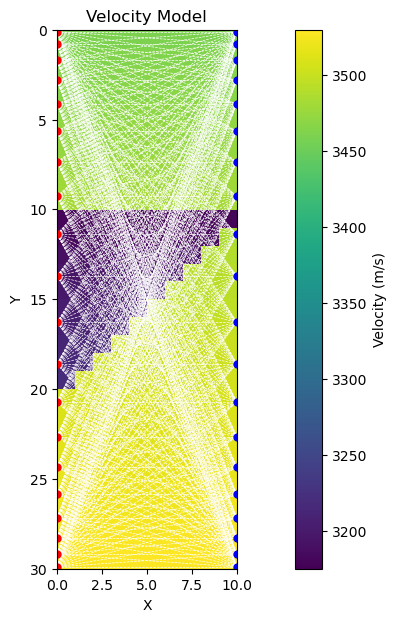

In [2]:
# Defind the velocity model
rows, cols = 30, 10
grid_size = (rows, cols)
velocity_model = velocity_generator(rows, cols)

# Define sources and receivers
# 0.1 and 29.9 are values close to limits
# Change linear to True to generate regular locations

# NOTE: create the z position not on the grid boundary to avoid conflict
z = device_location(n=20, rows=rows, new_min=0.1, new_max=29.9, linear=False)
sources = [(0, i) for i in z]
receivers = [(cols, i ) for i in z]

intersections = find_intersections(sources, receivers, grid_size=grid_size)
unique_intersections = remove_duplicate_intersections(intersections)
distances = calculate_distances(unique_intersections, grid_size=grid_size, sources=sources, receivers=receivers)

plot_velocity_model_with_sources_and_receivers(velocity_model, sources, receivers, cols, rows, showlines=True, linecolor='white', linewidth=.5)
# Print the distances for each receiver from each source.
# for s_idx, source in enumerate(sources):
#     for i, receiver in enumerate(receivers):
#         print(f"Receiver {i+1} at {receiver} from Source {s_idx+1} at {source}:")
#         print(distances[:, :, i, s_idx])

### Classical Inversion

In [3]:
D = []
T = []
s1 = 1/velocity_model

nreceiver = len(receivers)
nsource = len(sources)

for i in range(nsource):
    for j in range(nreceiver):
        D.append(distances[:,:,j,i].flatten())
        T.append(sum(sum(distances[:,:,j,i]*s1)))    
D = np.array(D)
Df = pd.DataFrame(D)
s1 = s1.flatten()

# Add noise
np.random.seed(99)
noise_percent = noise_generator(size=400, noise_level=0.001)
T = np.array(T)
T_noise = T + noise_percent*T

s, residuals, rank, s_val = np.linalg.lstsq(D, T_noise, rcond=None)
v_inversion = s**-1
v_inversion=v_inversion.reshape(rows,cols)
print(np.max(abs(s-s1)))
print(np.max(abs(D@(s1)-D@s)))

0.00021702145862724756
3.7062807035515705e-06


In [4]:
max((T-T_noise)/T)*100

0.04999826008383502

Text(0, 0.5, 'Y')

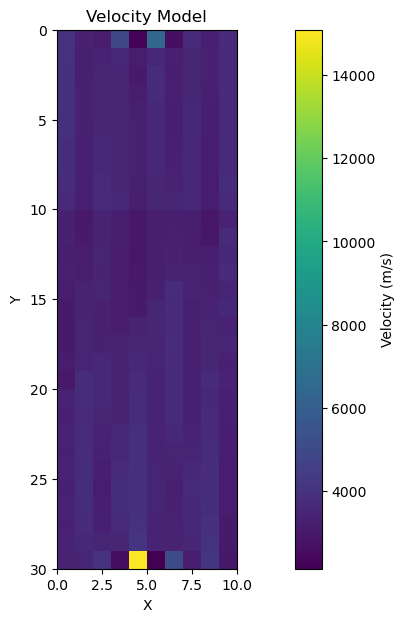

In [30]:
plt.figure(figsize=(15, 7))  
# plt.imshow(v_inversion, cmap='viridis', interpolation='nearest', extent=[0, cols, rows, 0], origin='upper', vmin=3175, vmax=3530)
plt.imshow(v_inversion, cmap='viridis', interpolation='nearest', extent=[0, cols, rows, 0], origin='upper')
plt.colorbar(label='Velocity (m/s)')
plt.title('Velocity Model')
plt.xlabel('X')
plt.ylabel('Y')

### By parts

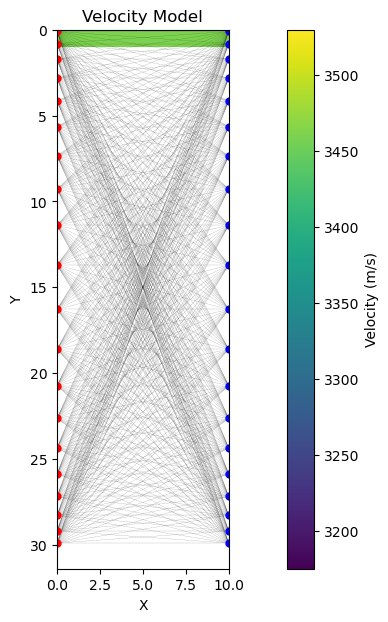

In [ ]:
velocity_01 = velocity_model[0,:]
velocity_01 = velocity_01.reshape(1, -1)
# np.savetxt('velocity_model.csv', velocity_model, delimiter=',', fmt='%.5f')


rows_new, cols_new = 1, 10
grid_size_new = (rows_new, cols_new)

# location of z does not change so use the original values
z = device_location(n=20, rows=rows, new_min=0.1, new_max=29.9, linear=False)
sources = [(0, i) for i in z]
receivers = [(cols, i ) for i in z]

intersections = find_intersections(sources, receivers, grid_size=grid_size_new)
unique_intersections = remove_duplicate_intersections(intersections)
distances = calculate_distances(unique_intersections, grid_size=grid_size_new, sources=sources, receivers=receivers)

plot_velocity_model_with_sources_and_receivers(velocity_01, sources, receivers, cols_new, rows_new, showlines=True, linecolor='black', linewidth=0.1)

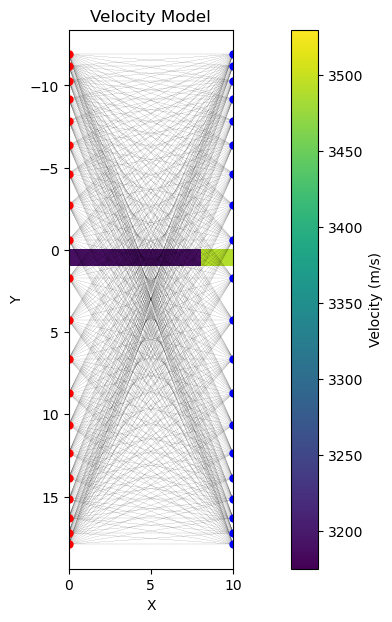

In [ ]:
layer = 12
velocity_01 = velocity_model[layer,:]
velocity_01 = velocity_01.reshape(1, -1)
# np.savetxt('velocity_model.csv', velocity_model, delimiter=',', fmt='%.5f')


rows_new, cols_new = 1, 10
grid_size_new = (rows_new, cols_new)

# location of z does not change so use the original values
z = device_location(n=20, rows=rows, new_min=0.1, new_max=29.9, linear=False)
z = z - layer
sources = [(0, i) for i in z]
receivers = [(cols, i ) for i in z]

intersections = find_intersections(sources, receivers, grid_size=grid_size_new)
unique_intersections = remove_duplicate_intersections(intersections)
distances = calculate_distances(unique_intersections, grid_size=grid_size_new, sources=sources, receivers=receivers)

plot_velocity_model_with_sources_and_receivers(velocity_01, sources, receivers, cols_new, rows_new, showlines=True, linecolor='black', linewidth=0.1)

In [ ]:
D = []
T = []
s1 = 1/velocity_01

nreceiver = len(receivers)
nsource = len(sources)

for i in range(nsource):
    for j in range(nreceiver):
        D.append(distances[:,:,j,i].flatten())
        T.append(sum(sum(distances[:,:,j,i]*s1)))    
D = np.array(D)
Df = pd.DataFrame(D)
s1 = s1.flatten()
# np.savetxt('Df.csv', Df, delimiter=',', fmt='%.5f')
Df;

In [ ]:
T = np.array(T)
indices_of_zero_np = np.where(T == 0)[0]
T_new = np.delete(T, indices_of_zero_np, axis=0)
D_new = np.delete(D, indices_of_zero_np, axis=0)
# np.savetxt('D_new.csv', D_new, delimiter=',', fmt='%.5f')

Df = pd.DataFrame(D_new)
Df;

### Testing

In [ ]:
s, residuals, rank, s_val = np.linalg.lstsq(D_new, T_new, rcond=None)
v_inversion = s**-1
v_inversion=v_inversion.reshape(rows_new,cols_new)
print(np.max(abs(s-s1)))
print(np.max(abs(D_new@(s1)-D_new@s)))

4.87890977618477e-19
8.673617379884035e-19


### Running a part of model

In [ ]:
M = D_new.copy()
I = np.ones(M.shape[1])  # Assuming M is a 2D numpy array
R = 3
t = T_new.copy()

L: 2.7874564459930292e-05


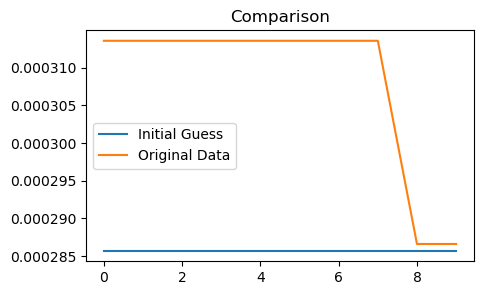

In [ ]:
# s0: initial guess -> 3500 m/s
s0 = np.ones(s.shape)*1/3500

plt.figure(figsize=(5,3))
plt.plot(s0, label='Initial Guess')
plt.plot(s1, label='Original Data')
plt.title('Comparison')
plt.legend()
print("L:",max(abs(s1-s0)))

Evaluating combinations: 100%|██████████| 10/10 [00:47<00:00,  4.70s/it]


0.07513898094930482


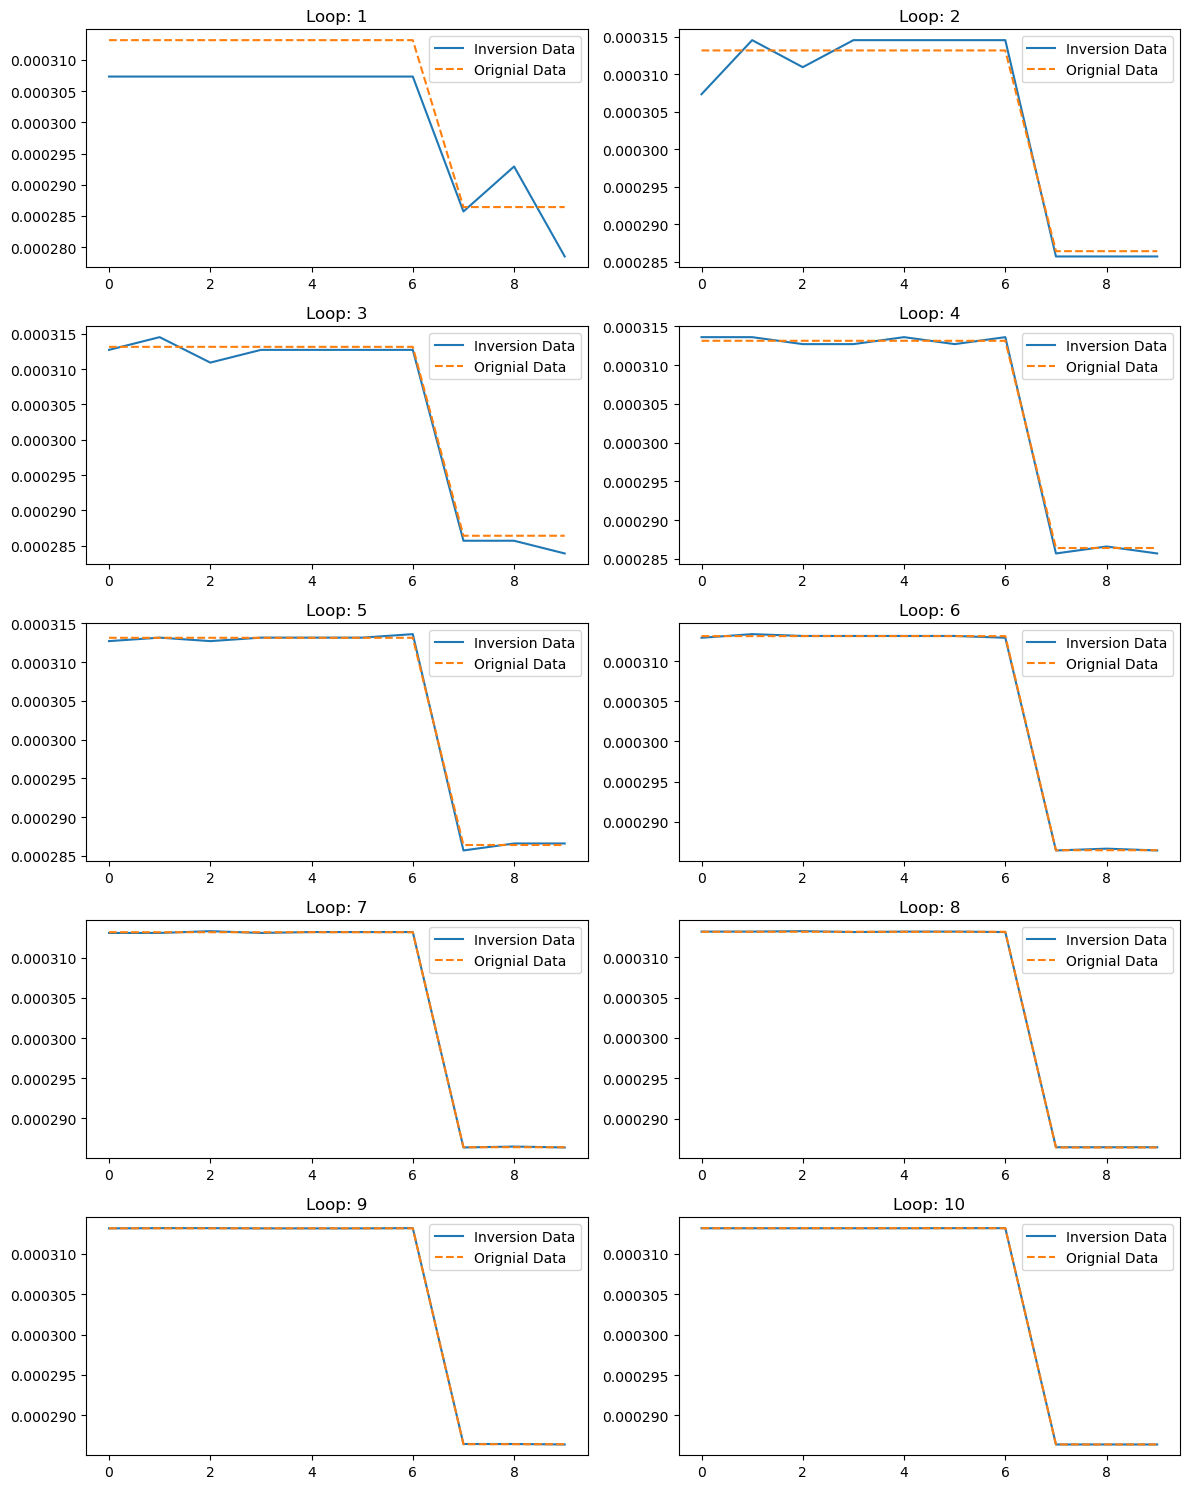

In [ ]:
s0 = np.ones(s.shape)*1/3500
A = construct_Ad(M, R, 1)
L = max(abs(s1-s0)) + 0.05*max(abs(s1-s0))

fig, axs = plt.subplots(5, 2, figsize=(12, 15))
directory = f'results30x10_{layer}'
os.makedirs(directory, exist_ok=True)

for i in tqdm(range(0, 10), desc="Evaluating combinations", colour='green'):
    b = (t + L*M@I - M@s0)/L

    Q = binary_least_squares_qubo(A, b)
    # Solve the QUBO using D-Wave's system
    sampler = EmbeddingComposite(DWaveSampler())
    sampleset = sampler.sample_qubo(Q, num_reads=100)
    # Print the best sample
    q = dict_to_vector_auto(sampleset.first.sample)
    x = binary2real(q, R, 2)
    
    # Update s
    s = s0 + L * (x - I)

    # NOTE: I do not use break condition because of the hardware limitation
    # Check if the solution is within the tolerance epsilon
    # if np.linalg.norm(s - s0) <= epsilon:
    #     break
    # else:
    #     s0 = s
    #     L = L / 2

    s0 = s
    L = L / 2

    axs[i // 2, i % 2].plot(s, label='Inversion Data')
    axs[i // 2, i % 2].plot(s1, label='Orignial Data', linestyle='dashed')
    axs[i // 2, i % 2].set_title(f'Loop: {i + 1}')
    axs[i // 2, i % 2].legend()

    filename = f'{directory}/s_{i}.txt'
    np.savetxt(filename, s)
fig.tight_layout()
print(max(abs(1/s1-1/s)))

### Running whole model

In [3]:
# Results
directory_base = 'results30x10-noise-2'
noise_level = 2e-2 # 2%
start_point = 0


# Defind the velocity model
rows, cols = 30, 10
grid_size = (rows, cols)
velocity_model = velocity_generator(rows, cols)

# Change z locations

for layer in tqdm(range(start_point,30), desc="Process", colour='green'):
    # -----------------------------------------------------------------
    # TODO: Part 1 - Create a part of velocity model, calculate travel time, ...
    velocity_01 = velocity_model[layer,:]
    velocity_01 = velocity_01.reshape(1, -1)

    rows_new, cols_new = 1, 10
    grid_size_new = (rows_new, cols_new)

    # location of z does not change so use the original values
    z = device_location(n=20, rows=rows, new_min=0.1, new_max=29.9, linear=False)
    z = z - layer
    sources = [(0, i) for i in z]
    receivers = [(cols, i ) for i in z]

    intersections = find_intersections(sources, receivers, grid_size=grid_size_new)
    unique_intersections = remove_duplicate_intersections(intersections)
    distances = calculate_distances(unique_intersections, grid_size=grid_size_new, sources=sources, receivers=receivers)

    # -----------------------------------------------------------------
    # TODO: Part 2 - Calculate D, T for running least square (paper)
    D = []
    T = []
    s1 = 1/velocity_01

    nreceiver = len(receivers)
    nsource = len(sources)

    for i in range(nsource):
        for j in range(nreceiver):
            D.append(distances[:,:,j,i].flatten())
            T.append(sum(sum(distances[:,:,j,i]*s1)))    
    D = np.array(D)
    Df = pd.DataFrame(D)
    s1 = s1.flatten()

    # -----------------------------------------------------------------
    # TODO: Part 3 - Create new T and new D
    T = np.array(T)
    indices_of_zero_np = np.where(T == 0)[0]

    # Add noise: it must be before remove 0 elements of T
    np.random.seed(42)
    noise_percent = noise_generator(size=400, noise_level=noise_level)
    T_noise = T + noise_percent*T

    T_new = np.delete(T_noise, indices_of_zero_np, axis=0)
    D_new = np.delete(D, indices_of_zero_np, axis=0)

    # -----------------------------------------------------------------
    # TODO: Part 4 - Create parameters, matrix for quantum annealing
    M = D_new.copy()
    I = np.ones(M.shape[1])  # Assuming M is a 2D numpy array
    R = 3
    t = T_new.copy()

    # -----------------------------------------------------------------
    # TODO: Part 5 - Annealing

    # s0: Initial guess
    # s1: Original data
    # s: iterative data
    s0 = np.ones(s1.shape)*1/3500 #--> Average velocity of the background
    A = construct_Ad(M, R, 1)
    L = max(abs(s1-s0)) + 0.05*max(abs(s1-s0))

    # fig, axs = plt.subplots(5, 2, figsize=(12, 15))
    directory = f'{directory_base}/{layer}'
    os.makedirs(directory, exist_ok=True)

    for i in range(0, 10):
        b = (t + L*M@I - M@s0)/L

        Q = binary_least_squares_qubo(A, b)
        # Solve the QUBO using D-Wave's system
        sampler = EmbeddingComposite(DWaveSampler())
        sampleset = sampler.sample_qubo(Q, num_reads=100)
        # Print the best sample
        q = dict_to_vector_auto(sampleset.first.sample)
        x = binary2real(q, R, 2)
        
        # Update s
        s = s0 + L * (x - I)

        # NOTE: I do not use break condition because of the hardware limitation

        s0 = s
        L = L / 2
        filename = f'{directory}/s_{i}.txt'
        np.savetxt(filename, s)
    
    print(f'{layer}:',max(abs(1/s1-1/s)))

Process:   0%|          | 0/30 [00:00<?, ?it/s]

Process:   3%|▎         | 1/30 [00:54<26:31, 54.86s/it]

0: 37.2638143251811


Process:   7%|▋         | 2/30 [01:55<27:16, 58.44s/it]

1: 62.619778125697394


Process:  10%|█         | 3/30 [02:44<24:21, 54.14s/it]

2: 17.592570015018737


Process:  13%|█▎        | 4/30 [03:39<23:37, 54.52s/it]

3: 44.1888302113407


Process:  17%|█▋        | 5/30 [04:27<21:38, 51.94s/it]

4: 18.956976639381537


Process:  20%|██        | 6/30 [05:16<20:24, 51.02s/it]

5: 27.31042628175237


Process:  23%|██▎       | 7/30 [06:05<19:19, 50.39s/it]

6: 20.05663408519922


Process:  27%|██▋       | 8/30 [06:52<18:01, 49.17s/it]

7: 13.111857757012785


Process:  30%|███       | 9/30 [07:43<17:23, 49.71s/it]

8: 11.754745248783365


Process:  33%|███▎      | 10/30 [08:40<17:21, 52.08s/it]

9: 13.553836900197439


Process:  37%|███▋      | 11/30 [09:23<15:34, 49.17s/it]

10: 7.841520883959674


Process:  40%|████      | 12/30 [10:20<15:29, 51.63s/it]

11: 26.118878628044513


Process:  43%|████▎     | 13/30 [11:07<14:14, 50.28s/it]

12: 7.20647370167535


Process:  47%|████▋     | 14/30 [11:52<13:00, 48.76s/it]

13: 15.873361205508445


Process:  50%|█████     | 15/30 [12:38<11:59, 47.98s/it]

14: 16.27129098811747


Process:  53%|█████▎    | 16/30 [13:25<11:06, 47.58s/it]

15: 7.487032926173015


Process:  57%|█████▋    | 17/30 [14:31<11:32, 53.23s/it]

16: 7.495082979266954


Process:  60%|██████    | 18/30 [15:27<10:48, 54.07s/it]

17: 11.714556364655436


Process:  63%|██████▎   | 19/30 [16:14<09:30, 51.84s/it]

18: 11.417919038066884


Process:  67%|██████▋   | 20/30 [17:00<08:19, 49.92s/it]

19: 8.668495533871464


Process:  70%|███████   | 21/30 [17:55<07:44, 51.59s/it]

20: 17.30264653283848


Process:  73%|███████▎  | 22/30 [18:54<07:11, 53.90s/it]

21: 9.962812412532912


Process:  77%|███████▋  | 23/30 [19:45<06:09, 52.83s/it]

22: 21.86271272804015


Process:  80%|████████  | 24/30 [20:36<05:14, 52.36s/it]

23: 15.123803037387006


Process:  83%|████████▎ | 25/30 [21:21<04:10, 50.15s/it]

24: 11.890904264081655


Process:  87%|████████▋ | 26/30 [22:06<03:14, 48.75s/it]

25: 23.277196598572573


Process:  90%|█████████ | 27/30 [23:10<02:39, 53.22s/it]

26: 25.331140608588157


Process:  93%|█████████▎| 28/30 [24:00<01:44, 52.33s/it]

27: 38.206401363193436


Process:  97%|█████████▋| 29/30 [24:53<00:52, 52.59s/it]

28: 31.132886486937878


Process: 100%|██████████| 30/30 [25:48<00:00, 51.62s/it]

29: 68.56495337781598
